# Подход к решению
Возможные подходы:
1. Разбить слова на слоги по правилам русского языка.  Слово будет "текстом", слоги будут играть роль "слов". Дальше используем стандартные средства работы с текстом (векторизация и эмбеддинг слогов и т.п.).
2. Разбить слова на буквы, делать векторизацию букв. Алгоритм сам будет выявлять закономерности

В этой версии использую второй подход.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import chime

In [2]:
%load_ext chime

In [3]:
df = pd.read_csv('train.csv', index_col='id'); df

,word,stress,num_syllables,lemma
id,,,,
0,румяной,2,3,румяный
1,цифрами,1,3,цифра
2,слугами,1,3,слуга
3,выбирает,3,4,выбирать
4,управдом,3,3,управдом
...,...,...,...,...
63433,экзамена,2,4,экзамен
63434,культурой,2,3,культура
63435,объемной,2,3,объемный


Для удобства сдвигаю нумерацию слогов, чтобы она начиналась с 0. Не забыть сдвинуть обратно окончательный прогноз!

In [4]:
df.stress = df.stress - 1

# Набор символов
Нахожу все используемые символы

In [5]:
def add_char(word):
    global alphabeth
    alphabeth = alphabeth.union(set(list(word)))

In [6]:
alphabeth = set()

In [7]:
df.word.apply(add_char)

id
0        None
1        None
2        None
3        None
4        None
         ... 
63433    None
63434    None
63435    None
63436    None
63437    None
Name: word, Length: 63438, dtype: object

In [8]:
df.lemma.apply(add_char)

id
0        None
1        None
2        None
3        None
4        None
         ... 
63433    None
63434    None
63435    None
63436    None
63437    None
Name: lemma, Length: 63438, dtype: object

In [9]:
alphabeth

{'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ё'}

Нумерую буквы

In [10]:
numbers = list(range(1, len(alphabeth) + 1))

In [11]:
alphabeth = {k: v for k, v in zip(list(alphabeth), numbers)}; alphabeth

{'р': 1,
 'о': 2,
 'м': 3,
 'б': 4,
 'э': 5,
 'е': 6,
 'ж': 7,
 'щ': 8,
 'ъ': 9,
 'в': 10,
 'л': 11,
 'ё': 12,
 'я': 13,
 'к': 14,
 'н': 15,
 'т': 16,
 'а': 17,
 'у': 18,
 'п': 19,
 'г': 20,
 'й': 21,
 'ч': 22,
 'д': 23,
 'с': 24,
 'ц': 25,
 'з': 26,
 'ф': 27,
 'ы': 28,
 'ш': 29,
 'ю': 30,
 'ь': 31,
 'и': 32,
 'х': 33}

# Подготовка данных 

Число символов и слова отдельно, т.к. подаю на разные входы нейронной сети

In [12]:
y = df.stress
num_syllables = df.num_syllables
X = df.drop(columns=['stress', 'num_syllables'])

Разделяем на буквы

In [13]:
word = X.word.apply(lambda x: ' '.join(list(x)))
lemma = X.lemma.apply(lambda x: ' '.join(list(x)))

In [14]:
word = word.str.split(expand=True); word

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
id,,,,,,,,,,,,,,,,,,,,
0,р,у,м,я,н,о,й,None,None,None,None,None,None,None,None,None,None,None,None,None
1,ц,и,ф,р,а,м,и,None,None,None,None,None,None,None,None,None,None,None,None,None
2,с,л,у,г,а,м,и,None,None,None,None,None,None,None,None,None,None,None,None,None
3,в,ы,б,и,р,а,е,т,None,None,None,None,None,None,None,None,None,None,None,None
4,у,п,р,а,в,д,о,м,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63433,э,к,з,а,м,е,н,а,None,None,None,None,None,None,None,None,None,None,None,None
63434,к,у,л,ь,т,у,р,о,й,None,None,None,None,None,None,None,None,None,None,None
63435,о,б,ъ,е,м,н,о,й,None,None,None,None,None,None,None,None,None,None,None,None


In [15]:
lemma = lemma.str.split(expand=True); lemma

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
id,,,,,,,,,,,,,,,,,,,,
0,р,у,м,я,н,ы,й,None,None,None,None,None,None,None,None,None,None,None,None,None
1,ц,и,ф,р,а,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,с,л,у,г,а,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,в,ы,б,и,р,а,т,ь,None,None,None,None,None,None,None,None,None,None,None,None
4,у,п,р,а,в,д,о,м,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63433,э,к,з,а,м,е,н,None,None,None,None,None,None,None,None,None,None,None,None,None
63434,к,у,л,ь,т,у,р,а,None,None,None,None,None,None,None,None,None,None,None,None
63435,о,б,ъ,е,м,н,ы,й,None,None,None,None,None,None,None,None,None,None,None,None


Отсутсвующая буква в конце слова - 0. (Альтернативный вариант - ragged tensors.)

In [16]:
word.fillna(0, inplace=True)
lemma.fillna(0, inplace=True)

In [17]:
alphabeth[0] = 0

Заменяю буквы на номера

In [18]:
word = word.applymap(lambda x: alphabeth[x])
lemma = lemma.applymap(lambda x: alphabeth[x])

In [19]:
lemma

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
id,,,,,,,,,,,,,,,,,,,,
0,1,18,3,13,15,28,21,0,0,0,0,0,0,0,0,0,0,0,0,0
1,25,32,27,1,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,24,11,18,20,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10,28,4,32,1,17,16,31,0,0,0,0,0,0,0,0,0,0,0,0
4,18,19,1,17,10,23,2,3,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63433,5,14,26,17,3,6,15,0,0,0,0,0,0,0,0,0,0,0,0,0
63434,14,18,11,31,16,18,1,17,0,0,0,0,0,0,0,0,0,0,0,0
63435,2,4,9,6,3,15,28,21,0,0,0,0,0,0,0,0,0,0,0,0


Объединяю

In [20]:
X = np.concatenate((word, lemma), axis=1)

In [21]:
X_train, X_val, y_train, y_val, num_syllables_train, num_syllables_val = train_test_split(
    X,
    y,
    num_syllables,
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

# Модель

In [22]:
embedding_dim = 33

In [23]:
word_input = keras.Input(
    shape=(40),
    name='words_and_lemmas'
)
syll_input = keras.Input(
    shape=(1),
    name='num_syllables'
)

w = layers.Embedding(
    input_dim=34,
    output_dim=embedding_dim,
    mask_zero=True,
    input_length=40)(word_input)
w = layers.LSTM(units=40,
               dropout=0.1)(w)

s = layers.Dense(1, activation='relu')(syll_input)

x = layers.concatenate([w, s])
x = layers.Dense(40, activation='relu')(x)
x = layers.Dropout(0.1)(x)

pred = layers.Dense(6, activation='softmax')(x)

model = keras.Model(
    inputs = [word_input, syll_input],
    outputs = [pred]
)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 words_and_lemmas (InputLayer)  [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 33)       1122        ['words_and_lemmas[0][0]']       
                                                                                                  
 num_syllables (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 40)           11840       ['embedding[0][0]']              
                                                                                              

In [25]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics='accuracy')

In [26]:
%%time
%%chime
history=model.fit(
    {'words_and_lemmas': X_train,
    'num_syllables': num_syllables_train},
    y_train,
    epochs=100,
    verbose=1,
    validation_split=0.1
)

Epoch 1/100
1428/1428 [==============================] - 25s 15ms/step - loss: 0.9431 - accuracy: 0.5765 - val_loss: 0.8141 - val_accuracy: 0.6357
Epoch 2/100
1428/1428 [==============================] - 20s 14ms/step - loss: 0.8100 - accuracy: 0.6437 - val_loss: 0.7848 - val_accuracy: 0.6532
Epoch 3/100
1428/1428 [==============================] - 20s 14ms/step - loss: 0.7681 - accuracy: 0.6669 - val_loss: 0.7344 - val_accuracy: 0.6765
Epoch 4/100
1428/1428 [==============================] - 20s 14ms/step - loss: 0.7372 - accuracy: 0.6845 - val_loss: 0.7314 - val_accuracy: 0.6904
Epoch 5/100
1428/1428 [==============================] - 21s 14ms/step - loss: 0.7056 - accuracy: 0.6999 - val_loss: 0.6663 - val_accuracy: 0.7178
Epoch 6/100
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6785 - accuracy: 0.7121 - val_loss: 0.6518 - val_accuracy: 0.7230
Epoch 7/100
1428/1428 [==============================] - 20s 14ms/step - loss: 0.6526 - accuracy: 0.7255 - val_loss: 0

In [27]:
history_pd = pd.DataFrame(history.history)

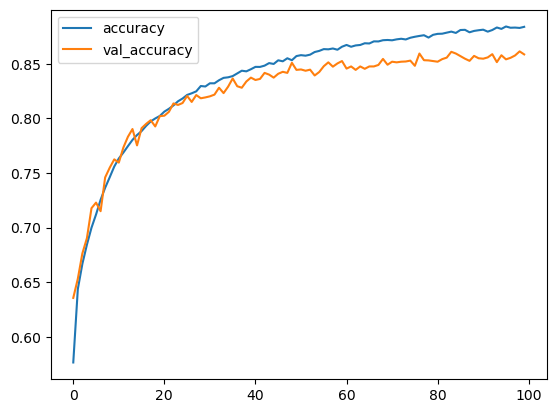

In [28]:
history_pd[['accuracy', 'val_accuracy']].plot.line();

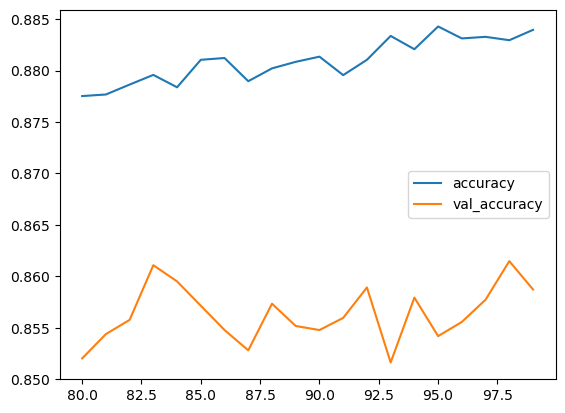

In [32]:
history_pd.loc[80:, ['accuracy', 'val_accuracy']].plot.line();

In [29]:
y_val_pred = model.predict({'words_and_lemmas': X_val,
    'num_syllables': num_syllables_val})

397/397 [==============================] - 3s 5ms/step


In [30]:
accuracy_score(y_val, y_val_pred.argmax(axis=1))

0.8566361916771753

Проверка на разумность: номер предсказанного ударного слога не должен быть больше числа слогов в слове.

In [31]:
(y_val_pred.argmax(axis=1) > num_syllables_val).sum()

0

# Прогноз на тестовой выборке 

## Подготовка данных 

In [33]:
test = pd.read_csv('test.csv', index_col='id'); test

,word,num_syllables,lemma
id,,,
0,эпилепсия,5,эпилепсия
1,относящейся,5,относиться
2,размышлениями,6,размышление
3,модемы,3,модем
4,солнц,1,солнце
...,...,...,...
29955,донбасса,3,донбасс
29956,обложка,3,обложка
29957,правителя,4,правитель


Число символов и слова отдельно, т.к. подаю на разные входы нейронной сети

In [34]:
num_syllables_test = test.num_syllables
X_test = test.drop(columns=['num_syllables'])

Разделяем на буквы

In [35]:
word_test = X_test.word.apply(lambda x: ' '.join(list(x)))
lemma_test = X_test.lemma.apply(lambda x: ' '.join(list(x)))

In [36]:
word_test = word_test.str.split(expand=True); word_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
id,,,,,,,,,,,,,,,,,,,
0,э,п,и,л,е,п,с,и,я,None,None,None,None,None,None,None,None,None,None
1,о,т,н,о,с,я,щ,е,й,с,я,None,None,None,None,None,None,None,None
2,р,а,з,м,ы,ш,л,е,н,и,я,м,и,None,None,None,None,None,None
3,м,о,д,е,м,ы,None,None,None,None,None,None,None,None,None,None,None,None,None
4,с,о,л,н,ц,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29955,д,о,н,б,а,с,с,а,None,None,None,None,None,None,None,None,None,None,None
29956,о,б,л,о,ж,к,а,None,None,None,None,None,None,None,None,None,None,None,None
29957,п,р,а,в,и,т,е,л,я,None,None,None,None,None,None,None,None,None,None


In [37]:
lemma_test = lemma_test.str.split(expand=True); lemma_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
id,,,,,,,,,,,,,,,,,,,
0,э,п,и,л,е,п,с,и,я,None,None,None,None,None,None,None,None,None,None
1,о,т,н,о,с,и,т,ь,с,я,None,None,None,None,None,None,None,None,None
2,р,а,з,м,ы,ш,л,е,н,и,е,None,None,None,None,None,None,None,None
3,м,о,д,е,м,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,с,о,л,н,ц,е,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29955,д,о,н,б,а,с,с,None,None,None,None,None,None,None,None,None,None,None,None
29956,о,б,л,о,ж,к,а,None,None,None,None,None,None,None,None,None,None,None,None
29957,п,р,а,в,и,т,е,л,ь,None,None,None,None,None,None,None,None,None,None


Отсутсвующая буква в конце слова - 0. (Альтернативный вариант - ragged tensors.)

In [38]:
word_test.fillna(0, inplace=True)
lemma_test.fillna(0, inplace=True)

Заменяю буквы на номера

In [39]:
word_test = word_test.applymap(lambda x: alphabeth[x])
lemma_test = lemma_test.applymap(lambda x: alphabeth[x])

In [40]:
lemma_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
id,,,,,,,,,,,,,,,,,,,
0,5,19,32,11,6,19,24,32,13,0,0,0,0,0,0,0,0,0,0
1,2,16,15,2,24,32,16,31,24,13,0,0,0,0,0,0,0,0,0
2,1,17,26,3,28,29,11,6,15,32,6,0,0,0,0,0,0,0,0
3,3,2,23,6,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,24,2,11,15,25,6,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29955,23,2,15,4,17,24,24,0,0,0,0,0,0,0,0,0,0,0,0
29956,2,4,11,2,7,14,17,0,0,0,0,0,0,0,0,0,0,0,0
29957,19,1,17,10,32,16,6,11,31,0,0,0,0,0,0,0,0,0,0


Объединяю

In [41]:
X_test = np.concatenate((word_test, lemma_test), axis=1); X_test

array([[ 5, 19, 32, ...,  0,  0,  0],
       [ 2, 16, 15, ...,  0,  0,  0],
       [ 1, 17, 26, ...,  0,  0,  0],
       ...,
       [19,  1, 17, ...,  0,  0,  0],
       [29,  6,  1, ...,  0,  0,  0],
       [ 2, 19, 16, ...,  0,  0,  0]])

## Прогноз 

In [42]:
y_test_pred = model.predict({'words_and_lemmas': X_test,
    'num_syllables': num_syllables_test})

937/937 [==============================] - 5s 4ms/step


In [43]:
y_test_pred = y_test_pred.argmax(axis=1)

In [44]:
(y_test_pred > num_syllables_test).sum()

0

In [45]:
submission = pd.DataFrame(data=y_test_pred, index=test.index, columns=['stress'])
submission.stress = submission.stress + 1
submission

,stress
id,
0,3
1,3
2,3
3,2
4,1
...,...
29955,2
29956,2
29957,2


In [46]:
submission.to_csv('submission_03.csv')